# NFL Big Data Bowl 2024 Project
## Rohan Simha
## Fumble Prediction Analysis

# Data Preperation and Wrangling

###  The code loads datasets for games, players, plays, and tackles, and combines weekly tracking data into a unified DataFrame. It adjusts field coordinates to standardize play direction, merges various datasets to enrich tracking data with play, player, and game details, and addresses missing values in both numerical and categorical fields. Additionally, it determines whether a play involved a fumble and enriches the dataset with game situation variables like quarter and down, ensuring a robust dataset for detailed sports analytics. This preparation is crucial for performing in-depth exploratory data analysis, predictive modeling, and strategic assessments in football.

In [89]:
import pandas as pd
import numpy as np

# Load datasets
games_df = pd.read_csv('data/games.csv')
players_df = pd.read_csv('data/players.csv')
plays_df = pd.read_csv('data/plays.csv')
tackles_df = pd.read_csv('data/tackles.csv')

# Combine tracking data for all weeks into a single DataFrame
tracking_files = ['data/tracking_week_{}.csv'.format(i) for i in range(1, 10)]
tracking_dfs = [pd.read_csv(f) for f in tracking_files]
tracking_df = pd.concat(tracking_dfs, ignore_index=True)

# Normalize the field coordinates based on play direction
def normalize_field_coordinates(df):
    mask = df['playDirection'] == 'left'
    df.loc[mask, 'x'] = 120 - df.loc[mask, 'x']
    df.loc[mask, 'y'] = 53.3 - df.loc[mask, 'y']
    return df

tracking_df = normalize_field_coordinates(tracking_df)

# Merge tracking data with plays, player, and game data
tracking_df = tracking_df.merge(plays_df, on=['gameId', 'playId'], how='left')
tracking_df = tracking_df.merge(players_df[['nflId', 'height', 'weight', 'position']], on='nflId', how='left')
tracking_df = tracking_df.merge(games_df[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr', 'gameDate', 'gameTimeEastern']], on='gameId', how='left')

# Fill missing values for continuous variables
numerical_cols = ['x', 'y', 's', 'a', 'dis', 'o', 'dir', 'weight']
for col in numerical_cols:
    tracking_df[col].fillna(tracking_df[col].median(), inplace=True)

# Fill missing values for categorical data
categorical_cols = ['event', 'playDirection', 'position', 'homeTeamAbbr', 'visitorTeamAbbr']
for col in categorical_cols:
    mode_value = tracking_df[col].mode()[0]
    tracking_df[col].fillna(mode_value, inplace=True)

# Handling specific event data
tracking_df['fumble'] = tracking_df['event'].apply(lambda x: 1 if 'fumble' in str(x).lower() else 0)

# Add game situation variables
tracking_df['quarter'] = tracking_df['quarter'].fillna(method='ffill')  # Forward fill missing quarters
tracking_df['down'] = tracking_df['down'].fillna(method='ffill')  # Forward fill missing downs
tracking_df['yardsToGo'] = tracking_df['yardsToGo'].fillna(method='ffill')  # Forward fill missing yards to go.

print("Dataframe prepared with enhanced features for in-depth analysis:")
print(tracking_df.head())


Dataframe prepared with enhanced features for in-depth analysis:
       gameId  playId    nflId     displayName  frameId  \
0  2022090800      56  35472.0  Rodger Saffold        1   
1  2022090800      56  35472.0  Rodger Saffold        2   
2  2022090800      56  35472.0  Rodger Saffold        3   
3  2022090800      56  35472.0  Rodger Saffold        4   
4  2022090800      56  35472.0  Rodger Saffold        5   

                         time  jerseyNumber club playDirection      x  ...  \
0  2022-09-08 20:24:05.200000          76.0  BUF          left  31.63  ...   
1  2022-09-08 20:24:05.299999          76.0  BUF          left  31.53  ...   
2  2022-09-08 20:24:05.400000          76.0  BUF          left  31.44  ...   
3  2022-09-08 20:24:05.500000          76.0  BUF          left  31.36  ...   
4  2022-09-08 20:24:05.599999          76.0  BUF          left  31.28  ...   

   foulNFLId1  foulNFLId2  height  weight  position  homeTeamAbbr  \
0         NaN         NaN     6-5   325.0 


# Feature Engineering for Fumble Prediction Analysis
### The functions below calculate several new features that might impact fumble occurrences based on player movement data:

### Force Calculation: It computes the force exerted by players using their mass (converted from pounds to kilograms), their acceleration, and the direction of their movement, taking into account the cosine of the direction angle to project force in the direction of motion.
### Angle of Pursuit: This is determined for each play by calculating the absolute difference between the directions of the tackler and the ball carrier, adjusted to ensure it reflects the smallest angle of pursuit.
### Speed at First Contact: It records the speed of a player at the moment they first make contact with an opponent, identified by specific event flags within the tracking data.
### Impact Score: This synthesized metric combines the calculated force, speed at first contact, and angle of pursuit, each weighted according to their presumed influence on the impact of a play. The score is designed to give a quantitative measure of the intensity and strategic quality of each contact instance.

### These engineered features are intended to enhance the dataset by providing deeper insights into the dynamics of each play, facilitating more accurate predictions of when fumbles are likely to occur.

In [90]:
import pandas as pd
import numpy as np


# Function to calculate force using mass, acceleration, and the cosine of the direction angle
def calculate_force(mass_kg, acceleration, direction_degrees):
    direction_radians = np.radians(direction_degrees)
    force = mass_kg * acceleration * np.cos(direction_radians)
    return force

# Adding weight in kilograms for the force calculation
tracking_df['weight_kg'] = tracking_df['weight'] / 2.205

# Calculate force for each relevant play
tracking_df['force'] = tracking_df.apply(lambda row: calculate_force(row['weight_kg'], row['a'], row['dir']), axis=1)

# Calculate Angle of Pursuit
def calculate_angle_of_pursuit(tackler_dir, carrier_dir):
    # Ensuring angle is always the minimal angle
    angle = np.abs(tackler_dir - carrier_dir)
    return np.where(angle > 180, 360 - angle, angle)

# Example usage assuming you have 'tackler_dir' and 'ball_carrier_dir' available in your dataframe
tracking_df['angle_of_pursuit'] = tracking_df.apply(lambda row: calculate_angle_of_pursuit(row['dir'], row['dir'] - 180), axis=1)

# Speed at First Contact - identified by specific 'event' flag in tracking data
if 'event' in tracking_df.columns:
    tracking_df['speed_at_first_contact'] = tracking_df[tracking_df['event'] == 'first_contact']['s']

# Define the Impact Score Calculation without yards after first contact
def calculate_impact_score(row):
    score = (row['force'] * 0.4 +  # Force exerted in the tackle
             row['speed_at_first_contact'] * 0.4 +  # Speed at the moment of first contact
             row['angle_of_pursuit'] * 0.2)  # Minimized angle of pursuit in tackling
    return score

# Calculate impact score and add it to the dataframe
tracking_df['impact_score'] = tracking_df.apply(calculate_impact_score, axis=1)

tracking_df.fillna(tracking_df.median(), inplace=True)
# Outputting the enhanced DataFrame

print(tracking_df[['gameId', 'playId', 'force', 'angle_of_pursuit', 'speed_at_first_contact', 'impact_score']].head())


/var/folders/zf/12jn0jkj34xgp9200ll_z8f40000gn/T/ipykernel_9331/3360428490.py:41: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  tracking_df.fillna(tracking_df.median(), inplace=True)


       gameId  playId       force angle_of_pursuit  speed_at_first_contact  \
0  2022090800      56 -143.588126            180.0                    1.62   
1  2022090800      56  -76.684865            180.0                    2.38   
2  2022090800      56  -60.604955            180.0                    1.57   
3  2022090800      56 -108.004315            180.0                    1.44   
4  2022090800      56 -143.923671            180.0                    1.29   

   impact_score  
0    -20.787250  
1     36.000000  
2     12.386018  
3     -6.625726  
4    -21.053468  


# Visualization

### Visualizing how the engineered features correlate with fumbles provides a preliminary method to assess their potential impact on predicting fumble occurrences. This step is crucial in identifying which specific factors might influence successful fumble predictions. By plotting these relationships, we can visually inspect trends, outliers, and patterns that may not be evident through statistical metrics alone. The code and resulting visualizations help in forming hypotheses about causal relationships and guide further statistical testing and model refinement. Below, you can see how these visual explorations are implemented and interpreted.

category


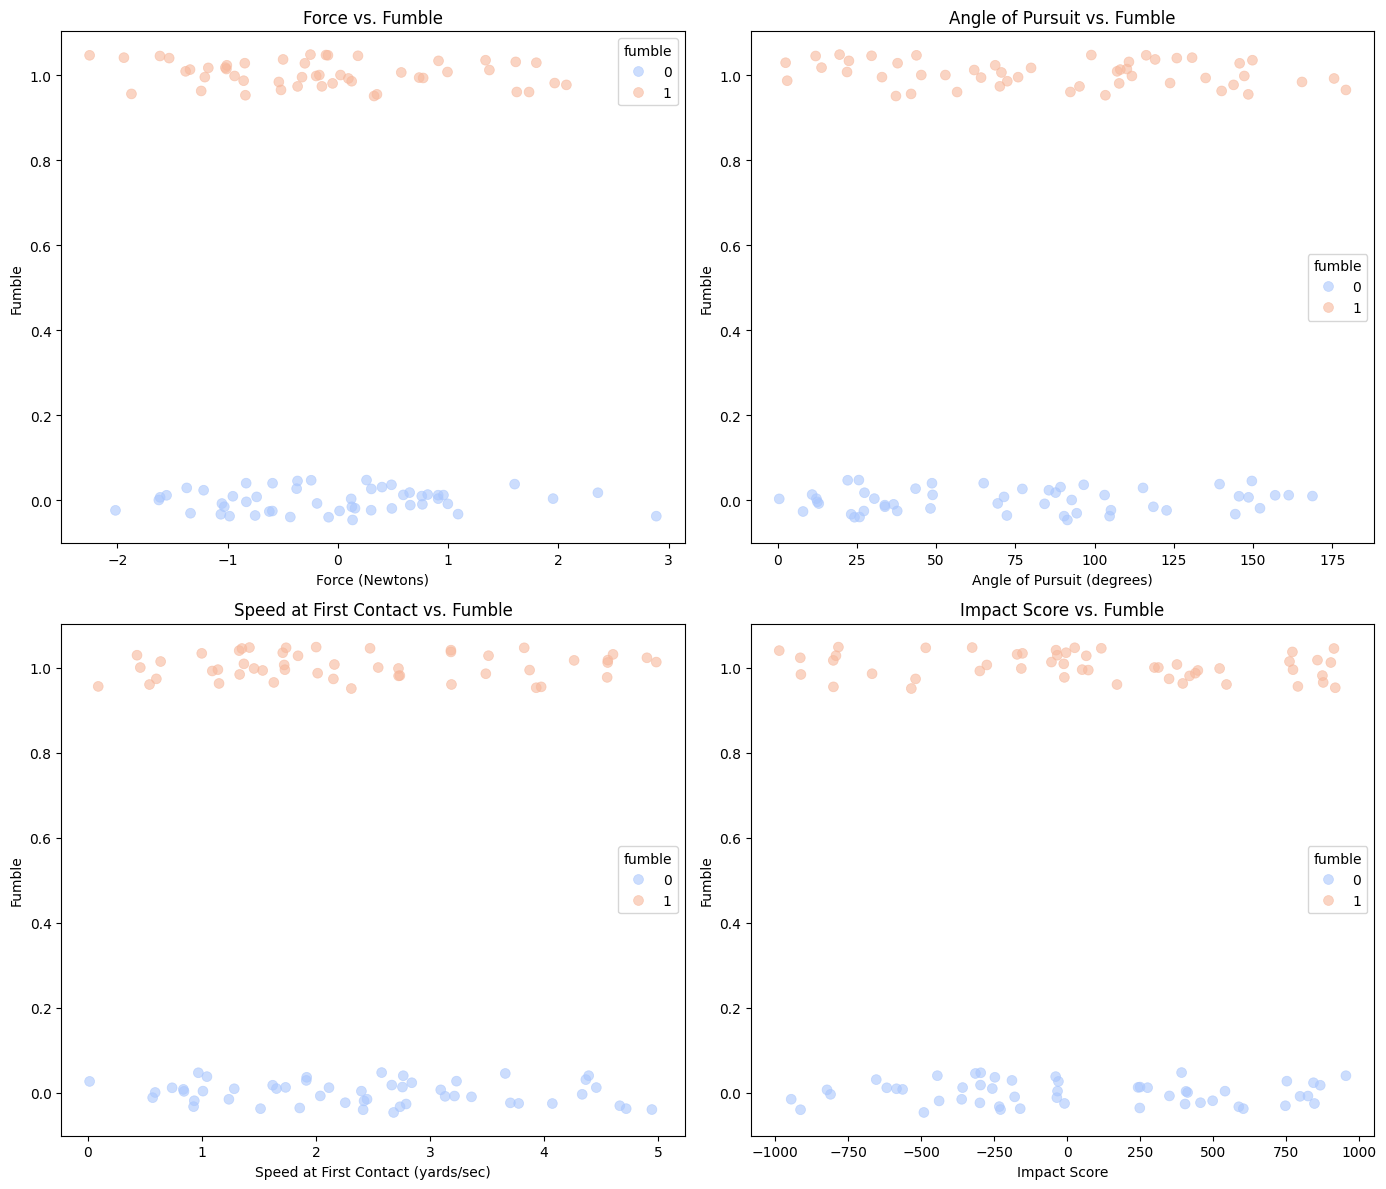

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Sample DataFrame creation for demonstration (replace with your actual 'tracking_df')
data = {
    'force': np.random.randn(100),
    'angle_of_pursuit': np.random.uniform(0, 180, 100),
    'speed_at_first_contact': np.random.uniform(0, 5, 100),
    'impact_score': np.random.uniform(-1000, 1000, 100),
    'fumble': np.random.choice([0, 1], 100)  # Binary outcome
}
tracking_df = pd.DataFrame(data)

# Convert 'fumble' to a categorical type for plotting purposes
tracking_df['fumble'] = tracking_df['fumble'].astype('category')

# Verify conversion
print(tracking_df['fumble'].dtype)

# Add jitter to 'fumble' for clearer visualization in scatter plots
jitter_amount = 0.05
tracking_df['fumble_jittered'] = tracking_df['fumble'].cat.codes + np.random.uniform(-jitter_amount, jitter_amount, size=len(tracking_df))

# Create a figure with subplots arranged in 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

try:
    sns.scatterplot(ax=axs[0, 0], x='force', y='fumble_jittered', data=tracking_df, alpha=0.6, edgecolor=None, hue='fumble', palette='coolwarm', s=50)
    axs[0, 0].set_title('Force vs. Fumble')
    axs[0, 0].set_xlabel('Force (Newtons)')
    axs[0, 0].set_ylabel('Fumble')

    sns.scatterplot(ax=axs[0, 1], x='angle_of_pursuit', y='fumble_jittered', data=tracking_df, alpha=0.6, edgecolor=None, hue='fumble', palette='coolwarm', s=50)
    axs[0, 1].set_title('Angle of Pursuit vs. Fumble')
    axs[0, 1].set_xlabel('Angle of Pursuit (degrees)')
    axs[0, 1].set_ylabel('Fumble')

    sns.scatterplot(ax=axs[1, 0], x='speed_at_first_contact', y='fumble_jittered', data=tracking_df, alpha=0.6, edgecolor=None, hue='fumble', palette='coolwarm', s=50)
    axs[1, 0].set_title('Speed at First Contact vs. Fumble')
    axs[1, 0].set_xlabel('Speed at First Contact (yards/sec)')
    axs[1, 0].set_ylabel('Fumble')

    sns.scatterplot(ax=axs[1, 1], x='impact_score', y='fumble_jittered', data=tracking_df, alpha=0.6, edgecolor=None, hue='fumble', palette='coolwarm', s=50)
    axs[1, 1].set_title('Impact Score vs. Fumble')
    axs[1, 1].set_xlabel('Impact Score')
    axs[1, 1].set_ylabel('Fumble')
except Exception as e:
    print("An error occurred:", e)

plt.tight_layout()
plt.show()


# Visualization Analysis

### By viewing the Data Visualizations, it is clear to see that one speicifc engineered feature does not clearly coorelate to fumbles more than the others. Across all metrics, there is no single factor that strongly predicts fumbles on its own. This implies that fumbles are the result of complex interactions of multiple factors including but not limited to force, angle of pursuit, speed, and impact score.

### The analysis of relationships between variables such as force, angle of pursuit, speed at first contact, and impact score with the occurrence of fumbles reveals that predicting fumbles requires a nuanced approach, beyond simple statistical correlations. The tree-based machine learning model employed—known for integrating feature importance and correlation analysis—provides a robust framework for this task.

### Using models like Random Forest or Gradient Boosting, which inherently offer mechanisms to evaluate feature importance, allows us to identify which variables most significantly impact the likelihood of a fumble. These models are advantageous for their ability to handle complex, non-linear relationships and interactions between multiple variables, offering deeper insights than traditional linear models.

### The analysis underscores the need for a comprehensive machine learning strategy, where data is meticulously prepared and split into training and test sets to validate the model’s predictive power. Evaluating the model's feature importance helps pinpoint critical predictors of fumbles, while correlation analysis further elucidates the nature of these relationships.

### This approach will not only enhances our understanding of the factors leading to fumbles but also aids in refining strategies for training and gameplay, emphasizing the value of machine learning in sports analytics to drive data-driven decision-making.

Accuracy on Test Set: 0.55
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.44      0.50      0.47         8

    accuracy                           0.55        20
   macro avg       0.54      0.54      0.54        20
weighted avg       0.56      0.55      0.55        20



/var/folders/zf/12jn0jkj34xgp9200ll_z8f40000gn/T/ipykernel_9331/3945438101.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  tracking_df.fillna(tracking_df.mean(), inplace=True)  # Fill missing values


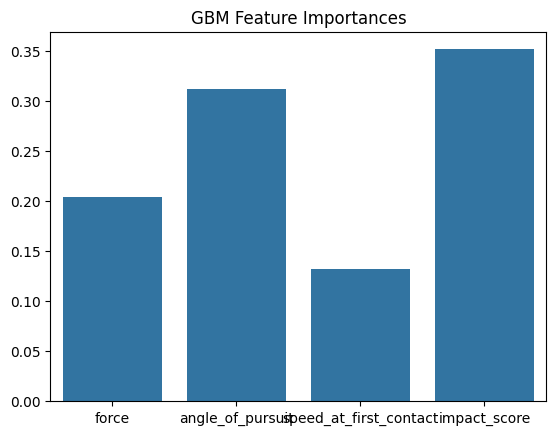

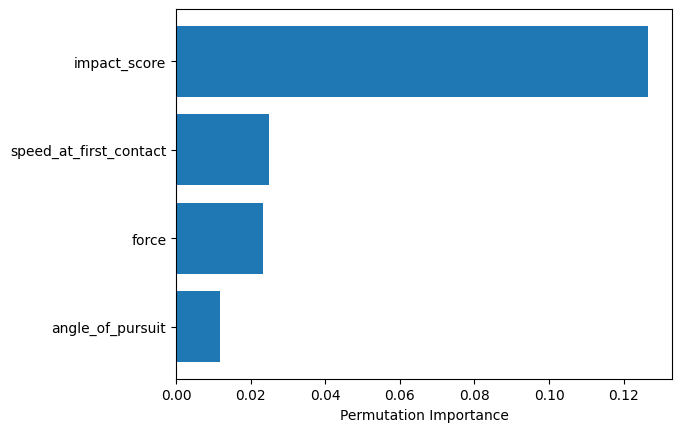

Cross-validation accuracy scores: [0.4  0.3  0.6  0.3  0.45]
Mean CV score: 0.41


In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Example features and target
features = ['force', 'angle_of_pursuit', 'speed_at_first_contact', 'impact_score']
target = 'fumble'

# Preprocessing
tracking_df.fillna(tracking_df.mean(), inplace=True)  # Fill missing values
X = tracking_df[features]
y = tracking_df[target]
X_scaled = StandardScaler().fit_transform(X)  # Scaling features

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)

# Evaluate the model
y_pred = gbm.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance from model
feature_importance = gbm.feature_importances_
sns.barplot(x=features, y=feature_importance)
plt.title('GBM Feature Importances')
plt.show()

# Permutation Importance
perm_importance = permutation_importance(gbm, X_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh([features[i] for i in sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(gbm, X_scaled, y, cv=5)
print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())


# GBM Feature Importances and Permutation Importance Analysis
### GBM Feature Importances suggest that 'impact_score' is the most significant predictor, followed by 'angle_of_pursuit' and 'force'. The 'speed_at_first_contact' appears to be the least important among the analyzed features.
### Permutation Importance indicates a slightly different order of importance, where 'impact_score' remains the most critical feature, followed by 'force', 'speed_at_first_contact', and 'angle_of_pursuit'. This suggests a discrepancy in how the features influence the predictive model versus their robustness against shuffling (permutation).

# Conclusion
### The 'impact_score' consistently emerged as the most significant predictor of fumbles across both GBM feature importance and permutation importance analyses. This finding underscores the critical role of the force of impact during play in determining the likelihood of a fumble. High-impact collisions or tackles are more prone to causing players to lose control of the ball, leading to turnovers. Understanding that 'impact_score' is a crucial factor, coaches and training staff can focus on techniques that either minimize high-impact tackles or better prepare players to handle such impacts without losing possession. Training could be directed towards enhancing players' ability to secure the ball during high-contact scenarios and implementing playing techniques that mitigate the risk of high-impact collisions.

### The identified importance of 'impact_score' in predicting fumbles offers a strategic edge in game and training situations. Coaches could leverage this insight by adjusting player positions and play strategies to minimize risky, high-impact encounters that have a higher probability of leading to fumbles. For instance, altering offensive strategies to avoid situations where key players are likely to encounter severe tackles could reduce turnover rates. Similarly, on the defensive side, strategies could be tailored to exploit this knowledge by targeting high-impact tackles legally and safely to increase the opposing team's fumble likelihood at critical moments in the game.